MNIST CNN Classification for FPGA implementation

Model Development

In [11]:
from __future__ import print_function

import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms
from torch.autograd import Variable

import numpy as np
from matplotlib import pyplot

from PIL import Image

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# MNIST Dataset
train_dataset = datasets.MNIST(root = './data/', train = True, transform = transforms.ToTensor(), download = True)
test_dataset  = datasets.MNIST(root = './data/', train = False, transform = transforms.ToTensor())

# Data Loader (Input Pipeline)
batch_size   = 64
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)
test_loader  = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = False)

100.0%
100.0%
100.0%
100.0%


In [6]:
class CNN(nn.Module):
     # Initialization
    def __init__(self):
        super (CNN, self).__init__()
        
        self.conv1_out_np = np.zeros((1, 3, 24, 24))
        self.mp1_out_np   = np.zeros((1, 3, 12, 12))
        
        self.conv2_out_np = np.zeros((1, 3, 8, 8))
        self.mp2_out_np   = np.zeros((1, 3, 4, 4))
        
        self.fc_in_np     = np.zeros((1, 48))
        self.fc_out_np    = np.zeros((1, 10))
        
        # 1st Convolution Layer
        # Image Input Shape -> (28, 28, 1)
        # Convolution Layer -> (24, 24, 3)
        # Pooling Max Layer -> (12, 12, 3)
        self.conv1        = nn.Conv2d(1, 3, kernel_size=5)
        
        # 2nd Convolution Layer
        # Image Input Shape -> (12, 12, 3)
        # Convolution Layer -> (8, 8, 3)
        # pooling Max Layer -> (4, 4, 3)
        self.conv2        = nn.Conv2d(3, 3, kernel_size=5)
        
        # Max Pooling Layer
        self.mp   = nn.MaxPool2d(2)
        
        # Fully Connected Layer
        # Num of Weight = 480
        self.fc_1 = nn.Linear(48, 10)
        
    def forward(self, x):
        in_size = x.size(0)
        
        # Layer Integration
        x = self.conv1(x)
        self.conv1_out_np = x.detach().numpy()
        
        x = F.relu(self.mp(x))
        self.mp1_out_np = x.detach().numpy()

        x = self.conv2(x)
        self.conv2_out_np = x.detach().numpy()
        
        x = F.relu(self.mp(x))
        self.mp2_out_np = x.detach().numpy()
        
        # Flatten Layer
        x = x.view(in_size, -1)
        self.fc_in_np = x.detach().numpy()
        
        # Fully Connected Layer
        x = self.fc_1(x)
        self.fc_out_np = x.detach().numpy()
        
        return F.log_softmax(x)		

In [5]:
# Instantiation
model = CNN()
print(model)

total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

CNN(
  (conv1): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(3, 3, kernel_size=(5, 5), stride=(1, 1))
  (mp): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_1): Linear(in_features=48, out_features=10, bias=True)
)
Number of parameters: 796


In [7]:
# Training
def train(epoch):
    model.train()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        
        optimizer.zero_grad()
        
        # Ouput of feedforwarding
        output = model(data)
        
        # Loss calibration
        loss = F.nll_loss(output, target)
        
        # Gradient
        loss.backward()
        
        # Back propagation
        optimizer.step()
        
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
# Test
def test():
    model.eval()

    test_loss = 0
    correct = 0
    
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        
        # Output of feedforwarding
        output = model(data)
        
        test_loss += F.nll_loss(output, target, size_average=False).item()
        
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
          
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))						

In [8]:
# Traning process
for epoch in range(1, 10):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.295420
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.278053
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.299701
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.286473
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.309746
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.298488
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.285126
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.273592
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.284173
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.272025
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.263491
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.248076
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.223349
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.175521
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.135850
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.108043
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.061913
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.041884
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.780281
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.702042
Train Epoch: 1 [12800/60000 (

Save Trained Weight and Bias

In [10]:
# Save model
# torch.save(model, "./cnn_mnist.pt")
torch.save(model.state_dict(), "./cnn_mnist_state_dict.pt")

# Load model
# model = torch.load("./cnn_mnist.pt", weights_only=False)
# model.eval()
# print(model)
model = CNN() 
model.load_state_dict(torch.load("./cnn_mnist_state_dict.pt"))
model.eval()

total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 796


Testing using a bitmap image

Predicted output: 3


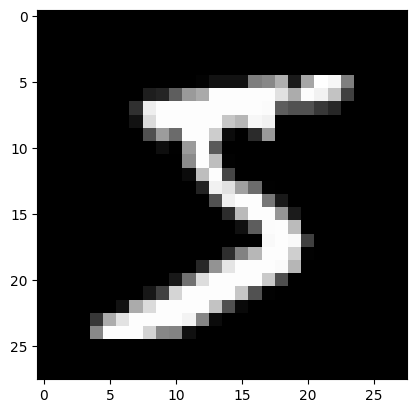

In [16]:
img       = Image.open("./bmp/train_0.bmp", "r")
np_img    = np.array(img)
pyplot.imshow(np_img, cmap=pyplot.get_cmap('gray'))

np_img_re = np.reshape(np_img, (1,1,28,28))
data      = Variable(torch.tensor((np_img_re / 255), dtype = torch.float32))

output    = model(data)
pred      = output.data.max(1, keepdim=True)[1]
print('Predicted output: ' + ', '.join(map(str, pred.flatten().tolist())))

Extracted Weight and Bias

In [18]:
# Calibration
int_conv1_weight_1 = torch.tensor((model.conv1.weight.data[0][0] * 128), dtype = torch.int32)
int_conv1_weight_2 = torch.tensor((model.conv1.weight.data[1][0] * 128), dtype = torch.int32)
int_conv1_weight_3 = torch.tensor((model.conv1.weight.data[2][0] * 128), dtype = torch.int32)
int_conv1_bias     = torch.tensor((model.conv1.bias.data * 128), dtype = torch.int32)

print("Signed")
print(int_conv1_weight_1)
print(int_conv1_weight_2)
print(int_conv1_weight_3)
print(int_conv1_bias)

# Converting to 2's Complement
for i in range(5):
    for j in range(5):
        if int_conv1_weight_1[i][j] < 0:
            int_conv1_weight_1[i][j] += 256
        if int_conv1_weight_2[i][j] < 0:
            int_conv1_weight_2[i][j] += 256
        if int_conv1_weight_3[i][j] < 0:
            int_conv1_weight_3[i][j] += 256

for k in range(3):
    if int_conv1_bias[k] < 0:
        int_conv1_bias[k] += 256

print ("Unsigned")
print(int_conv1_weight_1)
print(int_conv1_weight_2)
print(int_conv1_weight_3)
print(int_conv1_bias)

np.savetxt('conv1_weight_1.mem', int_conv1_weight_1, fmt='%1.2x',delimiter = " ")
np.savetxt('conv1_weight_2.mem', int_conv1_weight_2, fmt='%1.2x',delimiter = " ")
np.savetxt('conv1_weight_3.mem', int_conv1_weight_3, fmt='%1.2x',delimiter = " ")
np.savetxt('conv1_bias.mem', int_conv1_bias, fmt='%1.2x',delimiter = " ")

Signed
tensor([[-62, -49, -12,  39,  56],
        [-54, -26, -11,  35,  58],
        [-34, -36,  21,  31,  49],
        [-43, -19,  38,  58,  15],
        [-20,  19,  29,  70,   4]], dtype=torch.int32)
tensor([[ 21,   1, -20, -32, -11],
        [ 26,  18,  19, -11, -14],
        [ 28,  49,  82,  35,   0],
        [ 17,  43, 111,  97,  43],
        [ -2,  29,  66,  62,  87]], dtype=torch.int32)
tensor([[-21,   6,  -8,  -8, -36],
        [-29, -39, -53, -47, -34],
        [ -4, -34, -29,  -5, -22],
        [ 28,  33,  48,  11,  29],
        [ 18,  13,  23,  54,  50]], dtype=torch.int32)
tensor([-45,   0,  18], dtype=torch.int32)
Unsigned
tensor([[194, 207, 244,  39,  56],
        [202, 230, 245,  35,  58],
        [222, 220,  21,  31,  49],
        [213, 237,  38,  58,  15],
        [236,  19,  29,  70,   4]], dtype=torch.int32)
tensor([[ 21,   1, 236, 224, 245],
        [ 26,  18,  19, 245, 242],
        [ 28,  49,  82,  35,   0],
        [ 17,  43, 111,  97,  43],
        [254,  29,  6

In [19]:
# Calibration
# print(np.shape(model.conv2.weight))
int_conv2_weight_11 = torch.tensor((model.conv2.weight.data[0][0]* 128), dtype = torch.int32)
int_conv2_weight_12 = torch.tensor((model.conv2.weight.data[0][1]* 128), dtype = torch.int32)
int_conv2_weight_13 = torch.tensor((model.conv2.weight.data[0][2]* 128), dtype = torch.int32)

int_conv2_weight_21 = torch.tensor((model.conv2.weight.data[1][0] * 128), dtype = torch.int32)
int_conv2_weight_22 = torch.tensor((model.conv2.weight.data[1][1] * 128), dtype = torch.int32)
int_conv2_weight_23 = torch.tensor((model.conv2.weight.data[1][2] * 128), dtype = torch.int32)

int_conv2_weight_31 = torch.tensor((model.conv2.weight.data[2][0] * 128), dtype = torch.int32)
int_conv2_weight_32 = torch.tensor((model.conv2.weight.data[2][1] * 128), dtype = torch.int32)
int_conv2_weight_33 = torch.tensor((model.conv2.weight.data[2][2] * 128), dtype = torch.int32)

int_conv2_bias = torch.tensor((model.conv2.bias.data * 128), dtype = torch.int32)

print ("Signed")
print(int_conv2_weight_11)
print(int_conv2_weight_12)
print(int_conv2_weight_13, '\n')

print(int_conv2_weight_21)
print(int_conv2_weight_22)
print(int_conv2_weight_23, '\n')

print(int_conv2_weight_31)
print(int_conv2_weight_32)
print(int_conv2_weight_33, '\n')

print(int_conv2_bias)

# Converting to 2's Complement
for i in range(5):
    for j in range(5):
        if int_conv2_weight_11[i][j] < 0:
            int_conv2_weight_11[i][j] += 256
        if int_conv2_weight_12[i][j] < 0:
            int_conv2_weight_12[i][j] += 256
        if int_conv2_weight_13[i][j] < 0:
            int_conv2_weight_13[i][j] += 256
            
        if int_conv2_weight_21[i][j] < 0:
            int_conv2_weight_21[i][j] += 256
        if int_conv2_weight_22[i][j] < 0:
            int_conv2_weight_22[i][j] += 256
        if int_conv2_weight_23[i][j] < 0:
            int_conv2_weight_23[i][j] += 256
            
        if int_conv2_weight_31[i][j] < 0:
            int_conv2_weight_31[i][j] += 256
        if int_conv2_weight_32[i][j] < 0:
            int_conv2_weight_32[i][j] += 256
        if int_conv2_weight_33[i][j] < 0:
            int_conv2_weight_33[i][j] += 256

for k in range(3):
    if int_conv2_bias[k] < 0:
        int_conv2_bias[k] += 256

print ("Unsigned")
print(int_conv2_weight_11)
print(int_conv2_weight_12)
print(int_conv2_weight_13, '\n')

print(int_conv2_weight_21)
print(int_conv2_weight_22)
print(int_conv2_weight_23, '\n')

print(int_conv2_weight_31)
print(int_conv2_weight_32)
print(int_conv2_weight_33, '\n')

print(int_conv2_bias)

np.savetxt('conv2_weight_11.mem', int_conv2_weight_11, fmt='%1.2x',delimiter = " ")
np.savetxt('conv2_weight_12.mem', int_conv2_weight_12, fmt='%1.2x',delimiter = " ")
np.savetxt('conv2_weight_13.mem', int_conv2_weight_13, fmt='%1.2x',delimiter = " ")

np.savetxt('conv2_weight_21.mem', int_conv2_weight_21, fmt='%1.2x',delimiter = " ")
np.savetxt('conv2_weight_22.mem', int_conv2_weight_22, fmt='%1.2x',delimiter = " ")
np.savetxt('conv2_weight_23.mem', int_conv2_weight_23, fmt='%1.2x',delimiter = " ")

np.savetxt('conv2_weight_31.mem', int_conv2_weight_31, fmt='%1.2x',delimiter = " ")
np.savetxt('conv2_weight_32.mem', int_conv2_weight_32, fmt='%1.2x',delimiter = " ")
np.savetxt('conv2_weight_33.mem', int_conv2_weight_33, fmt='%1.2x',delimiter = " ")

np.savetxt('conv2_bias.mem', int_conv2_bias, fmt='%1.2x',delimiter = " ")

Signed
tensor([[ -7, -22,   3, -15, -11],
        [ 12, -24, -34, -27,   2],
        [ 18, -11, -26,  -3,  -2],
        [ -3,  -5,  19,   1,  -9],
        [ -9, -10,   8,  26,   0]], dtype=torch.int32)
tensor([[ 50,  30, -36, -29, -22],
        [ 28,  27,  38,   6, -55],
        [ 15,  21,  46,  49, -30],
        [ 10,  26,  40,  26, -27],
        [ 41,  16,   1,  -2, -14]], dtype=torch.int32)
tensor([[  1,  11,  16,   0,   1],
        [-33,  10,  16,  18,   0],
        [-35, -23, -22, -18,  -7],
        [-13, -19, -15, -22, -16],
        [ -6, -15,  -3,  -4,  -2]], dtype=torch.int32) 

tensor([[-36, -15,   4,  24,  17],
        [ -8,  -3,   8,  24,   4],
        [ 15,  13,  21,  18,   3],
        [  0,  38,   5,   5,  -7],
        [ 16,  37,   2, -28, -21]], dtype=torch.int32)
tensor([[-14, -24, -34, -12, -31],
        [-25,  12,  31,  11,  16],
        [  7,  64,  39,   8,   4],
        [ 50,  54,   4, -22, -15],
        [  7,  38, -22, -45, -13]], dtype=torch.int32)
tensor([[  7,  -

In [20]:
print(np.shape(model.fc_1.weight))
print((model.fc_1.weight * 128).int())

print(np.shape(model.fc_1.bias))
print((model.fc_1.bias * 128).int())

int_fc_weight = (model.fc_1.weight * 128).int()
int_fc_bias = (model.fc_1.bias * 128).int()

# Converting for 2's Complement
for i in range(10):
    for j in range(48):
        if int_fc_weight[i][j] < 0 :
            int_fc_weight[i][j] += 256
    if int_fc_bias[i] < 0 :
        int_fc_bias[i] += 256
        
print(int_fc_weight)
print(int_fc_bias)

np.savetxt('fc_weight.mem', int_fc_weight, fmt='%1.2x',delimiter = " ")
np.savetxt('fc_bias.mem', int_fc_bias, fmt='%1.2x',delimiter = " ")

torch.Size([10, 48])
tensor([[ 17,  21, -11,  31,   2, -13,  10,  27,  -2,  23,  17, -29,  16,  40,
          -5, -58,  -6,  29,  -9,  -3,  12,  17, -46,  -4,  -6, -10, -25,  36,
          -2,   0,  21,   7, -11,   0,  19,   0, -43, -16, -16,  20, -24, -22,
         -21,   4,  12,   6, -22,  34],
        [-11,   9,   2,  12,  15,   9, -16,  -7,   0,   0, -16,  10,   9, -16,
           5,  27,  -4, -39,  79, -17,  -3,  -3,  44, -29,  11, -30,  57, -50,
          17,  27, -15,  22,   9,  -2, -57, -48,   0, -20, -13, -35, -27, -27,
         -10,  -5, -24, -15,  38,  15],
        [ -7,  -2,   0,  26, -38, -13,  -6,  -3,  -8,   7,  -3, -60, -22, -10,
          29,  -7,  -3, -36, -32, -20,  44,   0,   2,  18,  31,  32,  33,   4,
          -7,   1, -26,  43,  46,  33,  14,  -8,  28,   0,   6, -38, -58,  12,
          -2,  31,   9,  -6,  20,  61],
        [ -2,  -1,  -6,  41, -59, -51, -10, -27,  -8, -20,  22,  10,  39,  -8,
           7, -16,  14, -30, -13,   2, -17,   0,   2, -23,  -7, -14, 